In [10]:
import cv2
import json
import numpy as np
from tqdm import tqdm
from pathlib import Path
from os.path import isfile, join, isdir
from os import makedirs
import matplotlib.pyplot as plt
import shutil
import random

plt.rcParams['figure.figsize'] = [20, 18]
random.seed = 1368

In [2]:
STD_CLASSES = {
    1: 'ball',
}

classes = STD_CLASSES

In [3]:
# Open json files and read the classes and gather all annotations and images
BASE_DIR = 'super_annotate_ball_path'
# dir_to_check = join(BASE_DIR, '17')
dir_to_check = BASE_DIR
all_images = list(Path(dir_to_check).rglob("*.png"))
all_annotations = list(Path(dir_to_check).rglob('*tations.json'))
all_classes = list(Path(dir_to_check).rglob('classes.json'))

def read_classes(path):
    cls_json = json.load(open(path))
    classes = {}
    for item in cls_json:
        classes[item['id']] = item['name'].lower()
    return classes

In [5]:
# Union the annotations with full address to images as keys of dictionary
annots_union = {}

for annot in all_annotations:
    js = json.load(open(annot.as_posix()))
    base_dir = annot.parent
    try:
        del js['___sa_version___']
    except KeyError:
        pass
    keys_to_remove = []
    js_with_full_path_keys = {}
    for key, value in js.items():
        full_address = join(base_dir, 'images', key)
        js_with_full_path_keys[full_address] = value
        keys_to_remove.append(key)

    annots_union.update(js_with_full_path_keys)

# del annots_union['___sa_version___']
# del js
# del all_annotations

In [6]:
# Check if all images are annotated.

if len(list(annots_union)) != len(all_images):
    all_images_keys = [item.name for item in all_images]
    all_annots_keys = list(annots_union.keys())
    for item in all_annots_keys:
        if item not in all_images_keys:
            print(item)
else:
    print("all images has corresponding annotations! OK")

all images has corresponding annotations! OK


In [11]:
BBOX_MODE = {
    'XYXY_ABS': 0,
    'XYWH_ABS': 1
}


class Bbox:
    """
    This class is implemented to give better control over annotations bounding boxes
    and its corresponding statistics. It can output bounding box statistics to
    darknet format and coco format.
    """

    def __init__(self, x1, y1, x2, y2, category_id=1, id_=None, image_id=None):
        self.id = id_
        self.x1 = int(min([x1, x2]))
        self.y1 = int(min([y1, y2]))
        self.x2 = int(max([x1, x2]))
        self.y2 = int(max([y1, y2]))
        self.image_id = image_id
        self.category_id = int(category_id)

    def __repr__(self):
        return f"""(Bbox(id={self.id}, x1={self.x1}, y1={self.y1}, x2={self.x2}, y2={self.y2}, width={abs(self.x1 - self.x2)}, height={abs(self.y1 - self.y2)}, category_id={self.category_id})"""

    def to_coco(self, bbox_mode=BBOX_MODE['XYXY_ABS']):
        """
        Convert information to coco format
        Args:
            bbox_mode: to output bbox as xyxy or xywh format.

        Returns(dict):

        """
        width = abs(self.x1 - self.x2)
        height = abs(self.y1 - self.y2)
        if bbox_mode == BBOX_MODE['XYWH_ABS']:
            return {
                'id': self.id,
                'category_id': self.category_id,
                'image_id': self.image_id,
                'iscrowd': 0,
                'bbox': [self.x1, self.y1, width, height],
                "area": width * height,
                "bbox_mode": BBOX_MODE['XYWH_ABS'],
            }

        else:
            return {
                'id': self.id,
                'category_id': self.category_id,
                'image_id': self.image_id,
                'iscrowd': 0,
                'bbox': [self.x1, self.y1, self.x2, self.y2],
                "area": width * height,
                "bbox_mode": BBOX_MODE['XYXY_ABS'],
            }

    def to_darknet(self):
        """
        prepares the x_center, y_center, width and height of
        the bounding box.
        Notes:
            you should be aware that we have to divide these
            values to the image_width and image_height to get
            a float number between 0 and 1. we do that on
            ImageAnnotation module.
        Returns:

        """
        width = abs(self.x1 - self.x2)
        height = abs(self.y1 - self.y2)

        x_cen = (self.x1 + width / 2)
        y_cen = (self.y1 + height / 2)

        return {
            'category_id': self.category_id,
            'x_cen': x_cen,
            'y_cen': y_cen,
            'width': width,
            'height': height
        }


class ImageAnnotations(object):
    """
    This module provides utility functions over image and its annotations.
    It can output json to COCO format and darknet.
    Capabilities:
        - It can filter out the categories of objects in the output json.
        - It can help you plot and test the objects in the image to check
             out the annotations. you can also filter certain objects in
             plot if you want
    """
    CATEGORIES = list(classes.keys())

    def __init__(self, image_id, file_name):
        self.image_id = image_id
        self.file_name = file_name
        assert isfile(file_name), f"file {file_name} does not exist"
        image = cv2.imread(file_name)
        self.height, self.width = image.shape[:2]
        self.annotations = []
        del image

    def add_annotation(self, bbox: Bbox):
        self.annotations.append(bbox)

    def __len__(self):
        return len(self.annotations)

    def __repr__(self):
        return f"""(ImageAnnotations object: file_name={self.file_name}, image_id={self.image_id}, width={self.width}, height={self.height}, n_annotations={len(self)})"""

    def to_coco_format(self, allowed_categories=()) -> dict:
        """
        Prepares the image details and the annotations on an image.
        Notes:
            The annotations must be assigned a unique integer. We have to
            do that only when we have access to all the annotations of all
            images. So there is a need for loop over all images and their
            annotations to assign unique integer for both image and
            corresponding annotations.
        Returns:

        """
        if not bool(allowed_categories):
            allowed_categories = self.CATEGORIES
            
        categories = []
        for k, v in classes.items():
            if k in allowed_categories:
                categories.append(k)

        map_cats_to_coco_format = {item: i for i, item in enumerate(categories, 1)}  # {1: 1, 4: 2, 6: 3}

        annots_details = []
        for annot in self.annotations:
            coco_info = annot.to_coco(BBOX_MODE['XYWH_ABS'])
            cat_id = coco_info['category_id']
            if cat_id not in allowed_categories:
                continue
            coco_info['category_id'] = map_cats_to_coco_format[cat_id] # coco categories start at 1 according to issues with Deteectron2
            coco_info['image_id'] = self.image_id
            annots_details.append(coco_info)
        image_info = {
            'id': self.image_id,
            'width': self.width,
            'height': self.height,
            'file_name': self.file_name
        }
        return {
            'image': image_info,
            'annotations': annots_details
        }

    def to_darknet_format(self, base_dir=None, allowed_categories=()):
        txt = ''
        if not bool(allowed_categories):
            allowed_categories = self.CATEGORIES

        """
        Darknet labels starts from 0 to n-1 classes
        So if we assume allowed_categories are [1, 4, 6] then all categories are sth like 
        [1, 2, ..., 10] for example. then we need to map [1, 4, 6] to [0, 1, 2] which 
        darknet is supposed to work with.

        """
        categories = []
        for k, v in classes.items():
            if k in allowed_categories:
                categories.append(k)

        map_cats_to_darknet_format = {item: i for i, item in enumerate(categories)}  # {1: 0, 4: 1, 6: 2}

        for annot in self.annotations:
            info = annot.to_darknet()
            category_id = info['category_id']
            if category_id not in allowed_categories:
                continue
            cat_id = map_cats_to_darknet_format[category_id]
            x_cen = info['x_cen'] / self.width
            y_cen = info['y_cen'] / self.height
            width = info['width'] / self.width
            height = info['height'] / self.height

            txt += f'{cat_id} {x_cen:.2f} {y_cen:.2f} {width:.2f} {height:.2f}\n'
        txt = txt[:-2]  # omitting last \n
        if base_dir:
            filename = Path(self.file_name).stem
            with open(join(base_dir, filename + '.txt'), 'w') as file:
                file.write(txt)
            return

        return {
            'file_name': self.file_name,
            'label_string': txt,
            'labels_included': {k: v for k, v in classes.items() if k in allowed_categories},
            'is_background': 1 if len(txt) == 0 else 0
            # when some image does not include any image, its totally background
        }

    # TODO: Define constant categories
    def coco_plot(self, allowed_categories=()):
        image = cv2.imread(self.file_name)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        colors = np.random.randint(low=0, high=255, size=(3, len(classes))).tolist()
        colormap = {item: colors[i] for i, item in enumerate(list(classes.values()))}
        font_face = cv2.FONT_HERSHEY_SIMPLEX
        font_scale = 1
        thickness = 3
        if not bool(allowed_categories):
            allowed_categories = self.CATEGORIES

        for annot in self.annotations:
            annot_info = annot.to_coco(bbox_mode=BBOX_MODE['XYXY_ABS'])
            category_id = annot_info['category_id']
            if category_id not in allowed_categories:
                continue
            x1, y1, x2, y2 = annot_info['bbox']
            category_name = classes[
                category_id]  # Mapping of category_id in superannotate starts from 1 but we insert categories from 0 because of coco standard format
            image = cv2.rectangle(image, (x1, y1), (x2, y2),
                                  color=colormap[category_name], thickness=3)
            text_org = (x1 - 5, y1 - 5)
            image = cv2.putText(image, f"{category_name.upper()}",
                                org=text_org, fontFace=font_face,
                                fontScale=font_scale, color=colormap[category_name],
                                thickness=thickness)
        return image

    @staticmethod
    def get_coco_categories(allowed_categories=()):
        categories = []
        temp = {}
        if not bool(allowed_categories):
            allowed_categories = list(classes.keys())
            
        i = 1
        for k, label in classes.items():
            if k in allowed_categories:
                temp['supercategory'] = label
                temp['id'] = i
                temp['name'] = label
                categories.append(temp.copy())
                i+=1
        return categories


In [12]:
"""
We register all images and bounding boxes with these stuff:
image:
    id
    width
    height
    filename (The address where it is going to be uploaded)

annotations:
    id
    image_id
    category_id
    iscrowd=0
    bbox ([x1, y1, x2, y2] or [x1, y1, width, height])
"""
bbox_index = 0
images_list = []
CLASSES_TO_INCLUDE = [1, 2, 3]  # The class ids that we are interested to involve in the object detection task.

for image_id, (file_name, annotations_info) in enumerate(tqdm(annots_union.items(), desc="processing images")):
    # We need two arguments for initializing the ImageAnnotations
    # image_id and filename
    image_and_annotation = ImageAnnotations(image_id=image_id, file_name=file_name)

    for instance in annotations_info['instances']:
        if (instance['type'] == 'bbox') and (instance['classId'] in CLASSES_TO_INCLUDE):
            points = instance['points']
            category_id = instance['classId']  # Classes has to start from 1
            x1, x2, y1, y2 = points['x1'], points['x2'], points['y1'], points['y2']
            bbox = Bbox(x1, y1, x2, y2, category_id, id_=bbox_index,
                        image_id=image_id)
            bbox_index += 1
            image_and_annotation.add_annotation(bbox)
    images_list.append(image_and_annotation)

100%|██████████| 1878/1878 [00:57<00:00, 32.63it/s]


In [13]:
# Random choice of the image to check for functions in Bbox and Annotation
rnd = random.choice(images_list)

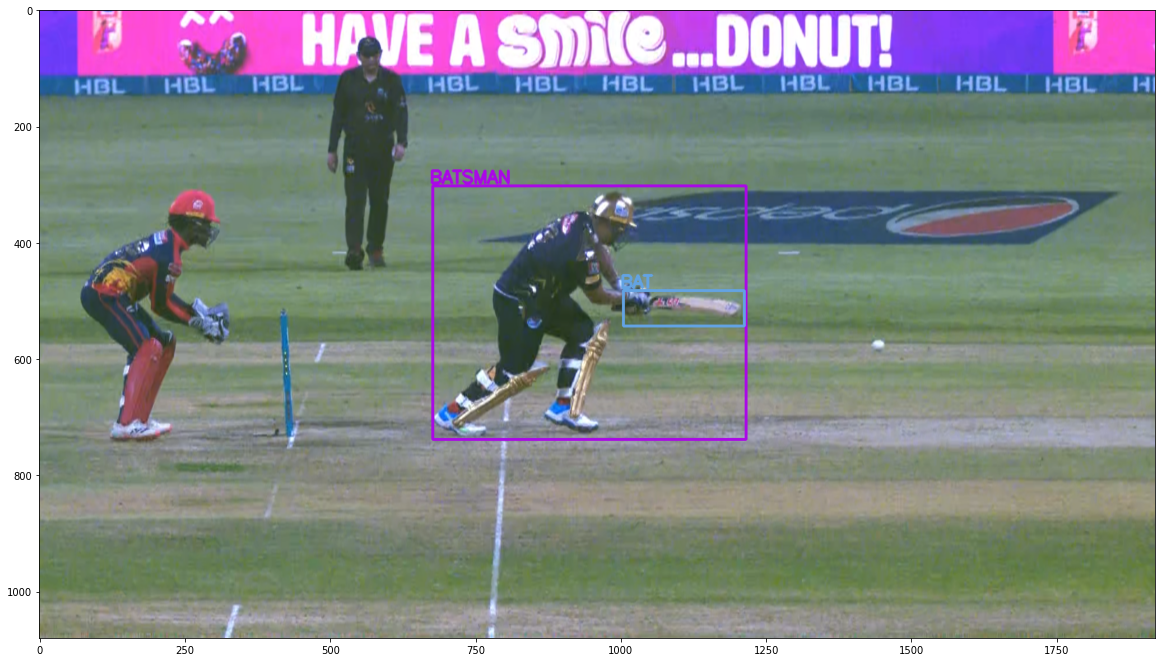

testing plot on image: OK


In [14]:
categories_to_plot = [1, 2]  # batsman and bat

plt.imshow(rnd.coco_plot(allowed_categories=categories_to_plot))
plt.show()
print("testing plot on image: OK")

In [15]:
allowed_categories = (1,)
js = rnd.to_coco_format(allowed_categories=allowed_categories)
print(js)
print("testing categories fileteration: OK")

{'image': {'id': 1416, 'width': 1920, 'height': 1080, 'file_name': 'batsman_data/jun20_rec1_and_4/images/772baa6a-dd5f-11eb-87d9-09e698989fee.png'}, 'annotations': [{'id': 5308, 'category_id': 1, 'image_id': 1416, 'iscrowd': 0, 'bbox': [677, 302, 539, 436], 'area': 235004, 'bbox_mode': 1}]}
testing categories fileteration: OK


In [16]:
images_list[0].get_coco_categories(allowed_categories=(1,))

[{'supercategory': 'batsman', 'id': 1, 'name': 'batsman'}]

In [37]:
js = rnd.to_darknet_format(allowed_categories=allowed_categories)
text = js['label_string'].split('\n')

if js['is_background'] == 0:
    for item in text:
        print(item)

print("testing categories fileteration on darknet output: OK")

0 0.45 0.29 0.11 0.1
testing categories fileteration on darknet output: OK


In [17]:
def coco_prepare(new_path_base_dir: str, image_annot_list: list, n_data: int,
                 json_filename: str, all_categories: list, allowed_categories=(1, 2, 3)):
    """
    This function is designed to create directories for train and validation in coco format.
    Args:
        new_path_base_dir: I use train/validation to pass this arg
        image_annot_list:
        n_data:
        json_filename:
        all_categories:
        allowed_categories:

    Returns:

    """
    coco_images = []
    coco_annotations = []

    if not isdir(new_path_base_dir):
        makedirs(new_path_base_dir)
    i = 0

    pbar = tqdm(total=n_data-1)

    while i < n_data:
        image_annot = image_annot_list.pop()
        output_js = image_annot.to_coco_format(allowed_categories)
        image_info = output_js['image']
        # Copying images in new path (train/val/test)
        old_path = Path(image_info['file_name'])
        new_path = join(new_path_base_dir, old_path.name)
        image_info['file_name'] = new_path
        shutil.copy2(old_path.as_posix(), new_path)
        annotation_info = output_js['annotations']
        for item in annotation_info:
            coco_annotations.append(item)
        coco_images.append(image_info)
        pbar.update(1)
        i += 1
    pbar.close()

    coco_annotations = sorted(coco_annotations, key=lambda x: x['id'])

    js = {
        'images': coco_images,
        'categories': all_categories,
        'annotations': coco_annotations
    }

    with open(json_filename, 'w') as file:
        json.dump(js, file, indent=2, sort_keys=True)

    print("converting to COCO over!")
    


def darknet_prepare(new_path_base_dir: str, image_annot_list: list, n_data: int, is_train=True, allowed_categories=()):
    """
    Move the images to new path and creates the labels for each image in darknet format.

    Args:
        new_path_base_dir:
        image_annot_list:
        n_data:
        is_train:
        allowed_categories:

    Returns:

    """
    base_images_dir = join(new_path_base_dir, 'images')
    base_labels_dir = join(new_path_base_dir, 'labels')

    if is_train:
        path_to_cp_images = join(base_images_dir, 'train')
        path_to_cp_labels = join(base_labels_dir, 'train')
    else:
        path_to_cp_images = join(base_images_dir, 'val')
        path_to_cp_labels = join(base_labels_dir, 'val')

    if not isdir(path_to_cp_labels):
        makedirs(path_to_cp_labels)

    if not isdir(path_to_cp_images):
        makedirs(path_to_cp_images)

    pbar = tqdm(total=n_data-1)
    i = 0
    while i < n_data:
        image_annot = image_annot_list.pop()
        old_path = Path(image_annot.file_name)
        new_img_path = join(path_to_cp_images, old_path.name)
        shutil.copy2(old_path.as_posix(), new_img_path)
        image_annot.to_darknet_format(base_dir=path_to_cp_labels, allowed_categories=allowed_categories)
        pbar.update(1)
        i += 1

    pbar.close()
    print("converting to darknet over!")

In [18]:
allowed_categories
ALLOWED_CATS = (1,)

to_darknet_flag = False
to_coco_flag = True

random.shuffle(images_list)

SIZE = len(images_list)

train_ratio = 0.8
# val_ratio = 0.2
# test_ratio = 0.1

TRAIN_PATH = 'dataset/train'
VAL_PATH = 'dataset/val'
DARKNET_PATH = 'darknet_dataset'

all_categories = images_list[0].get_coco_categories(allowed_categories=ALLOWED_CATS)
train_size = int(train_ratio * SIZE)
test_size = len(images_list) - train_size

if to_coco_flag:
    coco_prepare(TRAIN_PATH, images_list, train_size, 'train.json', all_categories, allowed_categories=ALLOWED_CATS)
    coco_prepare(VAL_PATH, images_list, test_size, 'test.json', all_categories, allowed_categories=ALLOWED_CATS)

if to_darknet_flag:
    darknet_prepare(DARKNET_PATH, images_list, train_size, is_train=True, allowed_categories=ALLOWED_CATS)
    darknet_prepare(DARKNET_PATH, images_list, test_size, is_train=False, allowed_categories=ALLOWED_CATS)

1502it [00:01, 892.07it/s]                          
 26%|██▌       | 96/375 [00:00<00:00, 956.87it/s]

converting to COCO over!


376it [00:00, 972.40it/s]                         

converting to COCO over!


In [ ]:
!zip -r new_coco_dataset.zip dataset/